# 05_Accessibility_b

#### Here we calculate accessibilty differently to [04_Accessibility]()

<div class="alert alert-block alert-warning"><b>ATTENTION:</b></div>

> **Unlike the `aggregate` function of the previous notebook; with this notebook we calculate accessibility through *nearest neighbor*. ~ specifically the `pandana` `.nearest_pois` which accepts a `distance` and `num_pois`.
> We extent the basic query and investigate *not the closest* amenity but second or third closest.**

> **Typically we don't choose the closest amenity. The shop around the way has a better bakery. The other park is pet friendly... and so forth ~ we add a parameter that allows us to investigate this.**  

<div class="alert alert-block alert-info"><b>Most of this notebook follows very similarly to the previous. Were applicable differences are highlighted.</b></div>

In [69]:
#load the magic

%matplotlib inline
import os
from pathlib import Path

import pandana as pdna
#from pandana.loaders import osm

import time
import numpy as np
import pandas as pd
#from shapely.geometry import Point
#from shapely.geometry import Polygon
#from shapely.geometry import box
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#set path
path = Path('./')

In [3]:
# load the dataset
amen_filename = path/'data/amenities_test.csv'
all_amenities = pd.read_csv(amen_filename)

In [4]:
all_amenities['amenity'].replace(
    to_replace=['supermarket', 'convenience', 'marketplace', 'kiosk', 'greengrocer'],
    value='food',
    inplace=True)

all_amenities['amenity'].replace(
    to_replace=['kindergarten'],
    value='school',
    inplace=True)

all_amenities['amenity'].replace(
    to_replace=['park', 'library', 'community_center'],
    value='local_activities',
    inplace=True)

all_amenities['amenity'].replace(
    to_replace=['restaurant', 'cafe', 'cinema', 'theatre', 'atm', 
                'bank', 'pharmacy', 'veterinary', 'internet_cafe'],
    value='social',
    inplace=True)

In [ ]:
#food = all_amenities[all_amenities['amenity'].isin(foodlist)]

In [5]:
all_amenities.amenity.value_counts()

social              795
local_activities    786
school              576
food                232
health_care          92
Name: amenity, dtype: int64

In [6]:
%%time
#load
net_filename = path/'data/osm2Way_network_CPT_walk.h5'

osm_walk_nodes = pd.HDFStore(net_filename).nodes
osm_walk_edges = pd.HDFStore(net_filename).edges

Wall time: 6.82 s


In [7]:
%%time
network = pdna.Network(osm_walk_nodes["x"],
                       osm_walk_nodes["y"], 
                       osm_walk_edges["from"], 
                       osm_walk_edges["to"],
                       osm_walk_edges[["distance"]],
                       twoway=True)
print('Network initialized')

Network initialized
Wall time: 14.2 s


In [93]:
full = (18.349529,-34.050469,18.649593,-33.848834)
west = (18.350216,-34.0499,18.550029,-33.850544)
north_east = (18.499218,-34.00039,18.649593,-33.848834)
central = (18.449779,-34.00039,18.599468,-33.849974)
cbd = (18.349529,-34.00039,18.500591,-33.848834)

cpt_object = 'https://citymaps.capetown.gov.za/agsext1/rest/services/Theme_Based/Open_Data_Service/MapServer/77/query?where=1%3D1&outFields=SUB_CNCL_NAME,OBJECTID,SUB_CNCL_NMBR&outSR=4326&f=json'
sub_shp = gpd.read_file(cpt_object)
sub_shp = sub_shp.set_crs(epsg=4326)

#### Set the amenities to the network

~ we set with 5 closest and a maximum distance of 5000 meter. *Our actual calculations will work within these bounds*.

In [91]:
min_distance = 1200
max_distance = 5000
num_close = 5

In [92]:
# initialize each amenity category with the locations (lon/lat coordinates)

for amenity in all_amenities.amenity.unique():
    amenities_subset = all_amenities[all_amenities['amenity'] == amenity]
    network.set_pois(category = amenity, maxdist = max_distance, 
                     maxitems = num_close, x_col=amenities_subset['lon'], y_col=amenities_subset['lat'])

<div class="alert alert-block alert-info">
<b>Calculate Accessibility and Plot:</b> Similarly we define a function but add one extra parameter</div>

> **We add a parameter `n` to visualize `1, 2, 3` and so on closests amenity.**

In [112]:
def plot_nearest_amenity(amenity, distance, n=1, zoom=full, cmap='PuBu_r'):
    '''
    define a function to calculate accessibilty given an amentiy and a distance.
    zoom and cmap are optional
    ~ will return a 1200 walking access and 5000 cycling access plot
    '''
    
    accessibility = network.nearest_pois(distance=distance, category=amenity, num_pois=num_close)
    
    #accessibility.name = "accessibility"
    accessibility = pd.DataFrame(accessibility[n])
    data = accessibility.merge(osm_walk_nodes, left_on='id', right_index=True, how = "left")
    if n == 1:
        add = 'st'
    if n == 2:
        add = 'nd'
    if n == 3:
        add = 'rd'
    if n == 4 and 5:
        add = 'th'

    if distance == 1200:
        mode = 'walking'
        speed = 3
    if distance == 5000:
        mode = 'cycling'
        speed = 12.5
    
    fig, ax = plt.subplots(figsize=(12,12))
    ax.axis([zoom[0], zoom[2], zoom[1], zoom[3]])

    plt.title('City of Cape Town:\n'+str(n)+ add+' nearest '+amenity+ ' within '+str(distance)+
              'm ('+str(round(((distance/1609)/speed)*60))+' minutes '+mode+')', size=20, pad=10)
    
    cb = plt.scatter(data.x, data.y, 
                     c=accessibility, s=0.5, cmap=cmap)#, 
                     #norm=matplotlib.colors.LogNorm())
    
    #add the city subcouncils
    sub_shp.boundary.plot(ax=ax, alpha =0.1, zorder=1)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.01)
    fig.colorbar(cb, cax=cax)
    
    plt.tight_layout()
    plt.show()

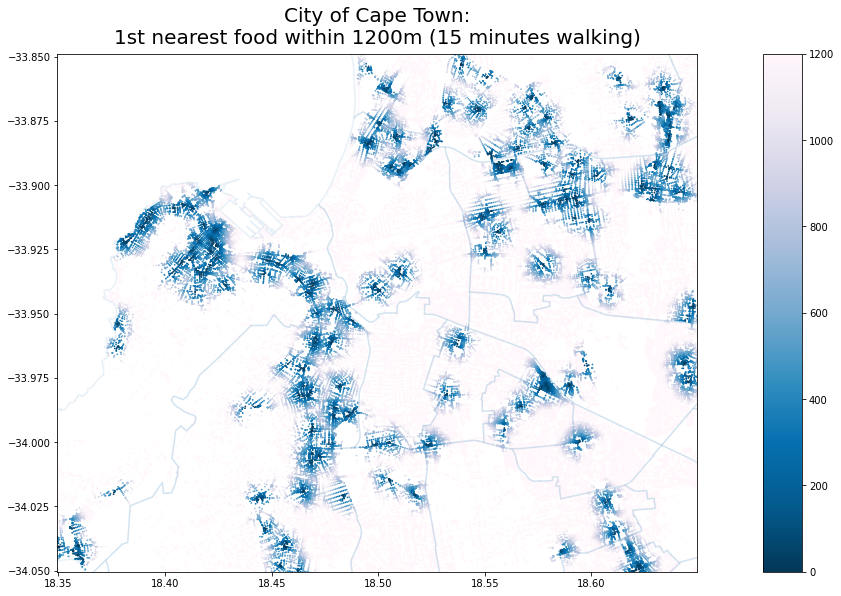

In [113]:
plot_nearest_amenity('food', 1200)

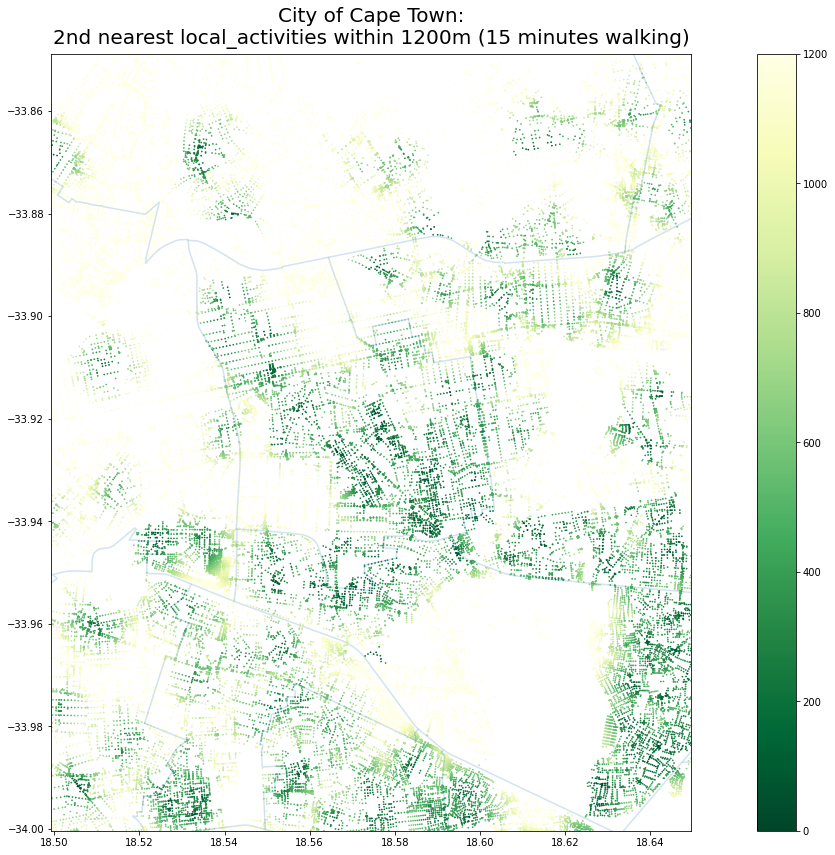

In [114]:
plot_nearest_amenity('local_activities', 1200, n=2, zoom=north_east, cmap='YlGn_r')

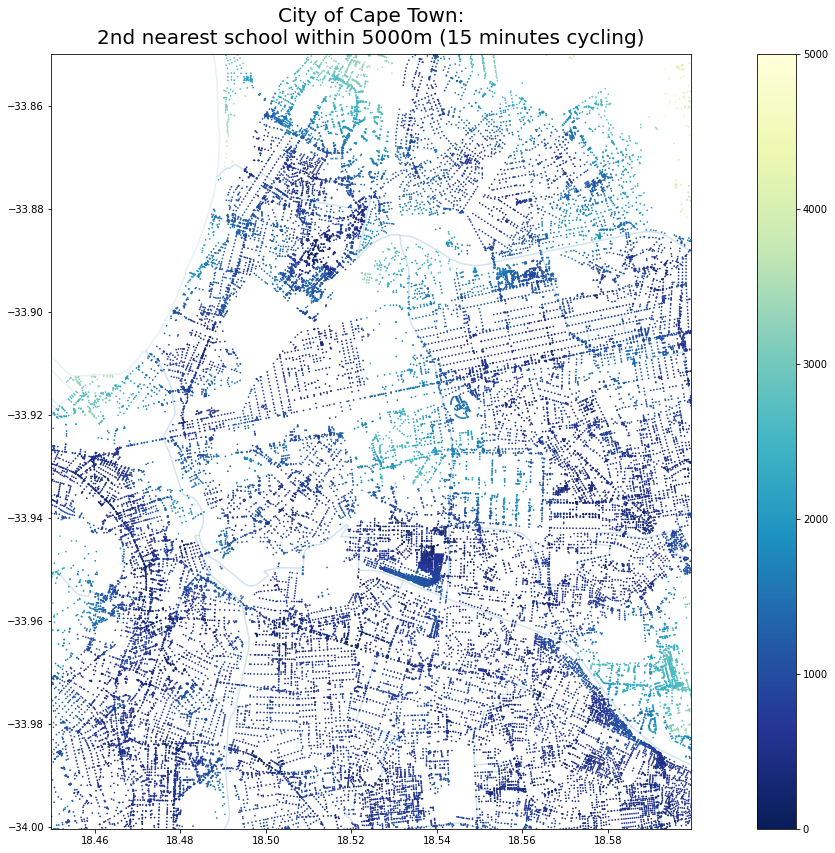

In [115]:
plot_nearest_amenity('school', 5000, n=2, zoom=central, cmap='YlGnBu_r')

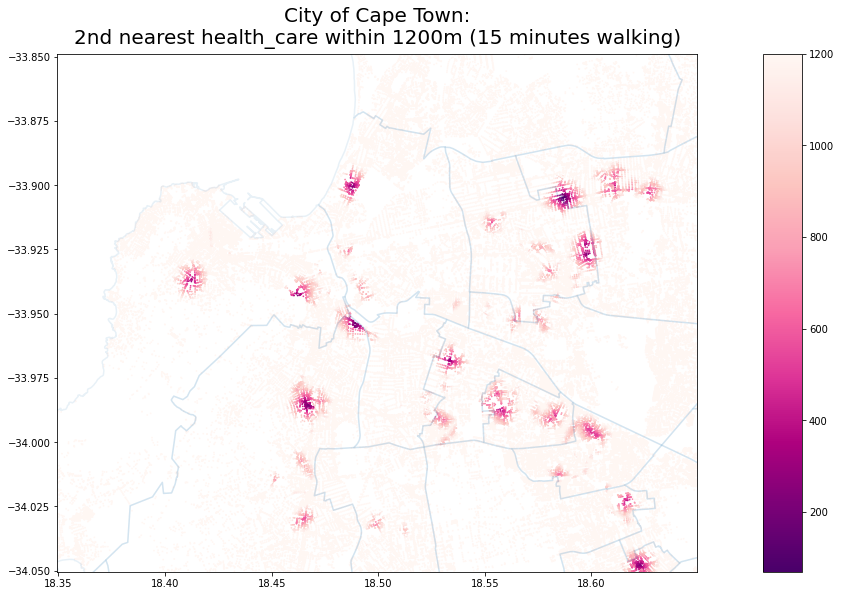

In [117]:
plot_nearest_amenity('health_care', 1200, n=2, zoom=full, cmap='RdPu_r')

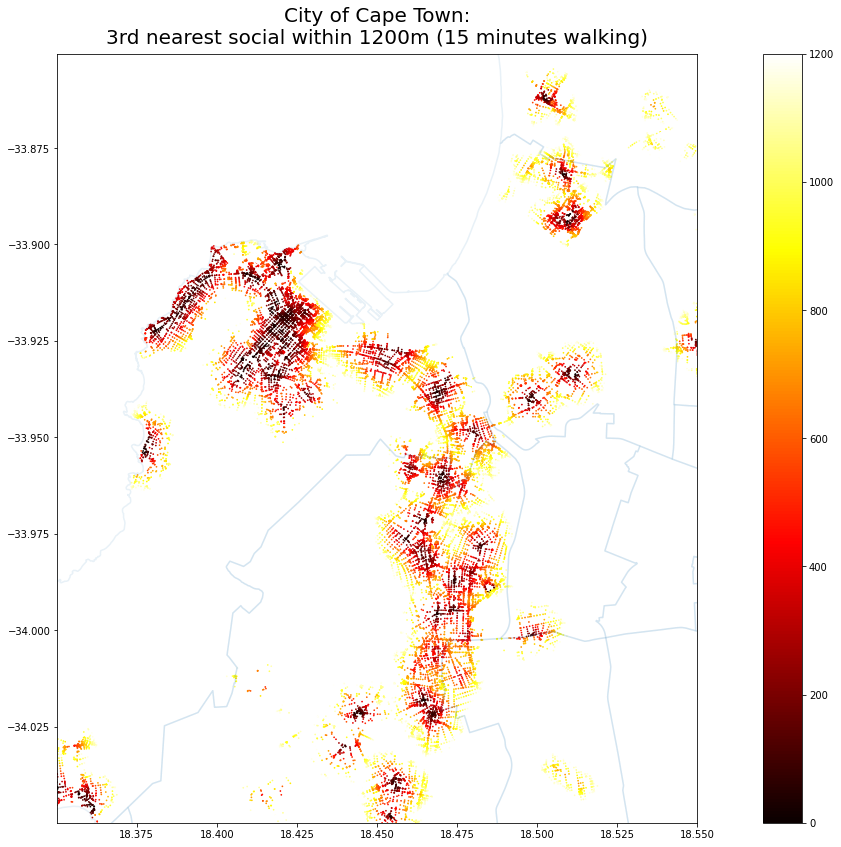

In [121]:
plot_nearest_amenity('social', 1200,  n=3, zoom=west, cmap='hot')